In [1]:
import pandas as pd
import numpy as np
import torch
import os
import torchvision
from torchvision.transforms import ToTensor, ToPILImage, Normalize, Compose,Resize
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms 

from torch.utils.data.sampler import SubsetRandomSampler,WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import random_split
from torchvision.datasets.utils import download_url
import matplotlib.pyplot as plt
import glob

In [2]:
pip install --upgrade efficientnet-pytorch

  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=d3124f642c95f431d8e81d2e846ee9c30237e9fbb2a6c091197bbaaa99bcb639
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch
Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.metrics import balanced_accuracy_score,f1_score
import zipfile
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torchvision import datasets, transforms as T
from efficientnet_pytorch import EfficientNet
import os
import torch.optim as optim
from PIL import ImageFile
from sklearn.metrics import accuracy_score
from PIL import Image
import PIL

In [4]:
from PIL import Image
import PIL

In [5]:
data_folder="../input/stylumia-complete/"

In [6]:
train_file=pd.read_csv(os.path.join(data_folder+'train_label.csv'))

In [7]:
train_file = train_file.sample(frac=1).reset_index(drop=True)

In [8]:
train_file

,file_name,label
0,Image_025438.jpg,7
1,Image_025019.jpg,6
2,Image_014310.jpg,2
3,Image_017924.jpg,4
4,Image_012618.jpg,0
...,...,...
31744,Image_009961.jpg,3
31745,Image_009375.jpg,3
31746,Image_007757.jpg,5
31747,Image_020485.jpg,6


In [9]:
train_file.loc[0,'label']

7

In [10]:
train_file

,file_name,label
0,Image_025438.jpg,7
1,Image_025019.jpg,6
2,Image_014310.jpg,2
3,Image_017924.jpg,4
4,Image_012618.jpg,0
...,...,...
31744,Image_009961.jpg,3
31745,Image_009375.jpg,3
31746,Image_007757.jpg,5
31747,Image_020485.jpg,6


In [11]:
train_file['label'].value_counts()

6     6285
3     4139
9     3933
7     3664
2     2778
5     2433
8     2338
0     2166
4     2052
10    1039
1      922
Name: label, dtype: int64

In [12]:
train_df=train_file.sample(frac=1).reset_index(drop=True)

In [13]:
train_df

,file_name,label
0,Image_029210.jpg,5
1,Image_023190.jpg,6
2,Image_014101.jpg,10
3,Image_019624.jpg,6
4,Image_014261.jpg,10
...,...,...
31744,Image_011338.jpg,3
31745,Image_010593.jpg,3
31746,Image_027944.jpg,7
31747,Image_027973.jpg,7


In [14]:
targets,count=np.unique(train_df['label'],return_counts=True)

In [15]:
targets

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [16]:
count

array([2166,  922, 2778, 4139, 2052, 2433, 6285, 3664, 2338, 3933, 1039])

In [17]:
weights=[sum(count)/c for c in count]

In [18]:
weights

[14.657894736842104,
 34.43492407809111,
 11.428725701943845,
 7.670693404203914,
 15.472222222222221,
 13.049321824907521,
 5.051551312649164,
 8.665120087336245,
 13.57955517536356,
 8.072463768115941,
 30.557266602502406]

In [19]:
example_weights=[weights[e] for e in train_df['label']]

In [20]:
len(example_weights)

31749

In [21]:
sampler=WeightedRandomSampler(example_weights,len(train_df['label']),replacement=True)

In [22]:
sampler

In [23]:
train_df

,file_name,label
0,Image_029210.jpg,5
1,Image_023190.jpg,6
2,Image_014101.jpg,10
3,Image_019624.jpg,6
4,Image_014261.jpg,10
...,...,...
31744,Image_011338.jpg,3
31745,Image_010593.jpg,3
31746,Image_027944.jpg,7
31747,Image_027973.jpg,7


In [24]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, images_folder,mode,stats,transform = ToTensor()):
        self.df = df
        self.mode=mode
        self.images_folder = os.path.join(images_folder+'/'+'train')
       
        self.transform1=Resize((260,260))
        self.train_tfms=tt.Compose([tt.RandomCrop(224,padding=4,padding_mode='reflect'),
                      tt.RandomHorizontalFlip(),
                      tt.ToTensor(),
                      tt.Normalize(*stats,inplace=True)])
        self.valid_tfms=tt.Compose([tt.ToTensor(),tt.Normalize(*stats,inplace=True)])

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        filename = self.df.loc[index, "file_name"]
        label = self.df.loc[index, "label"]
        image = PIL.Image.open(os.path.join(self.images_folder,filename))
        if self.mode=='train':
            image=self.transform1(image)
            image=self.train_tfms(image)
        else:
            image=self.transform1(image)
            image=self.valid_tfms(image)
        return image, label

In [25]:
img1=os.path.join(data_folder+'train/'+train_file.loc[12658,"file_name"])

In [26]:
img1

'../input/stylumia-complete/train/Image_012190.jpg'

In [27]:
len(train_file)

31749

In [28]:
image = PIL.Image.open(img1)

In [29]:
512/762

0.6719160104986877

In [30]:
x=transforms.Resize((256,256))

In [31]:
img=x(image)

In [32]:
img.size

(256, 256)

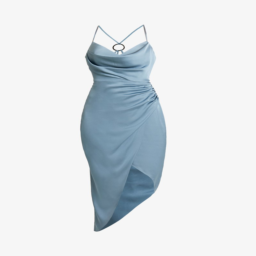

In [33]:
img

In [34]:
pwd

'/kaggle/working'

In [35]:
convert_tensor = torchvision.transforms.ToTensor()

convert_tensor(image)

tensor([[[0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647],
         [0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647],
         [0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647],
         ...,
         [0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647],
         [0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647],
         [0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647]],

        [[0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647],
         [0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647],
         [0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647],
         ...,
         [0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647],
         [0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647],
         [0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647]],

        [[0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647],
         [0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.9647],
         [0.9647, 0.9647, 0.9647,  ..., 0.9647, 0.9647, 0.

In [36]:
stats = ((0.7955, 0.7599, 0.7506), (0.2721, 0.2932, 0.2981))

In [37]:
train_dataset=CustomDataset(train_df,data_folder,'train',stats)

In [38]:
#val_indices

In [39]:
random_seed = 42
torch.manual_seed(random_seed);

In [40]:
train_dl = DataLoader(dataset=train_dataset, shuffle=False, batch_size=64, sampler=sampler)
#val_dl = DataLoader(dataset=val_dataset, shuffle=False, batch_size=64, sampler=val_sampler)

In [41]:
train_features, train_labels = next(iter(train_dl))
print(train_labels)


tensor([ 7,  8,  6,  2,  1,  9,  9,  6,  5,  5,  8,  9,  0,  2,  1,  6,  6,  5,
         1,  7,  8,  0,  2,  1,  6,  6,  3, 10, 10,  3,  0, 10, 10,  7,  3,  6,
         1,  0,  3,  6, 10,  1,  6,  3,  3, 10,  9,  6,  3,  6,  3, 10,  8, 10,
         4, 10,  8,  7,  6,  6,  3,  7,  2,  3])


In [42]:
torch.cuda.is_available()

True

In [43]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=4).permute(1,2,0))
        break

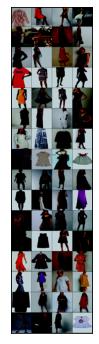

In [44]:
show_batch(train_dl)

In [45]:
class ImageClassificationBase(nn.Module):
 
    def training_step(self,batch):
        model.train()
        images,labels=batch
        out=self(images)
        loss=F.cross_entropy(out,labels)
        acc,mic,mac,bal_acc=accuracy(labels,out)
        return loss,acc,mic,mac,bal_acc
    
   
    def validation_step(self,batch):
        model.eval()
        images,labels=batch
        out=self(images)
        loss=F.cross_entropy(out,labels)
        acc,mic,mac,bal_acc=accuracy(labels,out)
        return {'val_loss':loss.detach(),'val_acc':acc,'val_mic':mic,'val_mac':mac,'val_balacc':bal_acc}
    
    
    def validation_epoch_end(self,result):
        loss=[x['val_loss'] for x in result]
        acc= [x['val_acc'] for x in result]
        mic=[x['val_mic'] for x in result]
        mac=[x['val_mac'] for x in result]
        bal=[x['val_balacc'] for x in result]
        l_b=torch.stack(loss).mean()
        a_b=torch.stack(acc).mean()
        mi_b=torch.stack(mic).mean()
        ma_b=torch.stack(mac).mean()
        ba_b=torch.stack(bal).mean()
        return {'val_loss':l_b.item(), 'val_acc': a_b.item(),'micro_f1':mi_b.item(), 'macro_f1': ma_b.item(),'bal_acc':ba_b.item()}
    
    def epoch_end(self,epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f},val_mic: {:.4f}, val_mac: {:.4f}, bal_acc: {:.4f}".format(
            epoch,result['val_loss'], result['val_acc'],result['micro_f1'], result['macro_f1'],result['bal_acc']))
        

In [46]:
class Classifier(ImageClassificationBase):
    def __init__(self,model_transfer):
        super(Classifier, self).__init__()
        self.eff =  model_transfer

    def forward(self, input):
        x = self.eff(input)
        return x


In [47]:
model_transfer= EfficientNet.from_pretrained('efficientnet-b2')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b2


In [48]:
#model_transfer

In [49]:

    #print(param)

In [50]:
in_features = model_transfer._fc.in_features
model_transfer._fc = nn.Sequential(
    nn.BatchNorm1d(num_features=in_features),    
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=128),
    nn.Dropout(0.4),
    nn.Linear(128, 11),
    )

In [51]:
model=Classifier(model_transfer)

In [52]:
model

Classifier(
  (eff): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_proje

In [53]:
model.load_state_dict(torch.load('../input/eff-net-b2/res_cust_2.pth'))


<All keys matched successfully>

In [54]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [55]:
device = get_default_device()
device

device(type='cuda')

In [56]:
train_dl = DeviceDataLoader(train_dl, device)
#val_dl = DeviceDataLoader(val_dl, device)

In [57]:
train_dl

In [58]:
model = to_device(model, device)
model

Classifier(
  (eff): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_proje

In [59]:
def accuracy(act,pred):
    _, preds = torch.max(pred, dim=1)
    #print(preds[0])
    #print("a")
    #print(act[0])
    act2=act.detach().cpu().numpy()
    pred2=preds.detach().cpu().numpy()
    acc=torch.tensor(torch.sum(preds==act).item() / len(preds))
    mic=f1_score(act2, pred2, average='micro')
    mac=f1_score(act2, pred2, average='macro')
    bal_acc=balanced_accuracy_score(act2, pred2)
    return acc,torch.tensor([mic]),torch.tensor([mac]),torch.tensor([bal_acc])

In [60]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [61]:
def fit(model,train_dl,opt,lr,epochs):
    history = []
    optimizer = opt(model.parameters(), lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min',patience=0,verbose=True,factor=0.1)
    for epoch in range(epochs):
        epoch_acc=[]
        epoch_bal_acc=[]
        epoch_f1=[]
        loss_epo=[]
        for batch in train_dl:
            images,labels=batch
            loss,acc,mic,mac,bal_acc=model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_acc.append(acc)
            epoch_bal_acc.append(bal_acc)
            epoch_f1.append(mac)
            loss2=loss.clone().detach()
            loss_epo.append(loss2)
        dic_train=torch.stack(epoch_acc).mean()
        dic_bal=torch.stack(epoch_bal_acc).mean()
        dic_f1=torch.stack(epoch_f1).mean()
        loss_val=torch.stack(loss_epo).mean()
        
        print("Epoch [{}], train_loss: {:.4f},train_acc: {:.4f},train_bal_acc: {:.4f},train_f1: {:.4f}".format(
        epoch,loss_val,dic_train,dic_bal,dic_f1))

        #res=[model.validation_step(batch) for batch in val_dl ]
        #dic=model.validation_epoch_end(res)
        #valid_loss=dic['val_loss']
        scheduler.step(loss_val)
        #history.append(dic)
        #model.epoch_end(epoch,dic)
    return "india"

In [62]:
opt=torch.optim.Adam

In [63]:
a=10e-5
print(a)

0.0001


In [64]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [65]:
from torchsummary import summary
#summary(model,input_size=(3,260,260))

In [66]:
fit(model,train_dl,opt,2*10e-5,5)  

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Epoch [0], train_loss: 0.4604,train_acc: 0.8519,train_bal_acc: 0.8624,train_f1: 0.8384
Epoch [1], train_loss: 0.4362,train_acc: 0.8561,train_bal_acc: 0.8669,train_f1: 0.8432
Epoch [2], train_loss: 0.3838,train_acc: 0.8727,train_bal_acc: 0.8841,train_f1: 0.8610
Epoch [3], train_loss: 0.4009,train_acc: 0.8676,train_bal_acc: 0.8794,train_f1: 0.8561
Epoch     4: reducing learning rate of group 0 to 2.0000e-05.
Epoch [4], train_loss: 0.3377,train_acc: 0.8872,train_bal_acc: 0.8967,train_f1: 0.8755


'india'

In [67]:
torch.save(model.state_dict(), 'res_cust_3.pth')
torch.save(model, 'res_cust_whole3.pkl')

In [68]:
fit(model,train_dl,opt,2*10e-6,5)

Epoch [0], train_loss: 0.3067,train_acc: 0.8984,train_bal_acc: 0.9069,train_f1: 0.8874
Epoch [1], train_loss: 0.2897,train_acc: 0.9035,train_bal_acc: 0.9143,train_f1: 0.8944
Epoch [2], train_loss: 0.2767,train_acc: 0.9094,train_bal_acc: 0.9188,train_f1: 0.8999
Epoch [3], train_loss: 0.2610,train_acc: 0.9152,train_bal_acc: 0.9254,train_f1: 0.9073
Epoch [4], train_loss: 0.2435,train_acc: 0.9204,train_bal_acc: 0.9277,train_f1: 0.9104


'india'

In [69]:
torch.save(model.state_dict(), 'res_cust_4.pth')
torch.save(model, 'res_cust_whole4.pkl')

In [70]:
import glob

In [71]:
from os import listdir
onlyfiles = [f for f in listdir('../input/stylumia-complete/test')]

In [72]:
#onlyfiles

In [73]:
file_name=[]
for name in glob.glob('../input/stylumia-complete/test/*'):
    file_name1=name.split('/')
    #print(file_name1[-1])
    file_name.append(file_name1[-1])

In [74]:
test_df=pd.DataFrame()

In [75]:
test_df['file_name']=pd.Series(file_name)

In [76]:
test_df

,file_name
0,Image_test_015339.jpg
1,Image_test_015427.jpg
2,Image_test_006765.jpg
3,Image_test_009681.jpg
4,Image_test_002734.jpg
...,...
18218,Image_test_017934.jpg
18219,Image_test_008324.jpg
18220,Image_test_010326.jpg
18221,Image_test_001255.jpg


In [77]:
data_folder="../input/stylumia-complete/"

In [78]:
class CustomDataset_test(torch.utils.data.Dataset):
    def __init__(self, df, images_folder,mode,stats,transform = ToTensor()):
        self.df = df
        self.mode=mode
        self.images_folder = os.path.join(images_folder+'test')
       
        self.transform1=Resize((260,260))
        self.train_tfms=tt.Compose([tt.RandomCrop(112,padding=4,padding_mode='reflect'),
                      tt.RandomHorizontalFlip(),
                      tt.ToTensor(),
                      tt.Normalize(*stats,inplace=True)])
        self.valid_tfms=tt.Compose([tt.ToTensor(),tt.Normalize(*stats,inplace=True)])

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        filename = self.df.loc[index, "file_name"]
        #print(os.path.join(self.images_folder,filename))
        image = PIL.Image.open(os.path.join(self.images_folder,filename))
        if self.mode=='train':
            image=self.transform1(image)
            image=self.train_tfms(image)
        else:
            image=self.transform1(image)
            image=self.valid_tfms(image)
        return image,filename

In [79]:
dataset_test=CustomDataset_test(test_df,data_folder,"test",stats)

In [80]:
test_dl = DataLoader(dataset=dataset_test, shuffle=True, batch_size=64)

In [81]:
for i in test_dl:
    #print(i)
    break

In [82]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [83]:
device = get_default_device()
device

device(type='cuda')

In [84]:
for image in test_dl:
    print(image)
    break

[tensor([[[[ 0.7083,  0.7083,  0.7083,  ...,  0.6651,  0.6651,  0.6651],
          [ 0.7083,  0.7083,  0.7083,  ...,  0.6651,  0.6651,  0.6651],
          [ 0.7083,  0.7083,  0.7083,  ...,  0.6651,  0.6651,  0.6651],
          ...,
          [ 0.6651,  0.6651,  0.6651,  ...,  0.2183,  0.2183,  0.2183],
          [ 0.6651,  0.6651,  0.6651,  ...,  0.2183,  0.2183,  0.2183],
          [ 0.6651,  0.6651,  0.6651,  ...,  0.2183,  0.2183,  0.2183]],

         [[ 0.7788,  0.7788,  0.7788,  ...,  0.7253,  0.7253,  0.7253],
          [ 0.7788,  0.7788,  0.7788,  ...,  0.7253,  0.7253,  0.7253],
          [ 0.7788,  0.7788,  0.7788,  ...,  0.7253,  0.7253,  0.7253],
          ...,
          [ 0.7386,  0.7386,  0.7386,  ...,  0.2839,  0.2839,  0.2839],
          [ 0.7386,  0.7386,  0.7386,  ...,  0.2839,  0.2839,  0.2839],
          [ 0.7386,  0.7386,  0.7386,  ...,  0.2839,  0.2839,  0.2839]],

         [[ 0.7709,  0.7709,  0.7709,  ...,  0.7182,  0.7182,  0.7182],
          [ 0.7709,  0.7709, 

In [85]:
def predict(test_dl,model):
    ans=[]
    file_names=[]
    model.eval()
    for batch in test_dl:
        with torch.no_grad():
            images,names=batch
            images=images.to(device=device)
            out=model(images)
        #print(out)
        #print(type(out))
            _, preds = torch.max(out, dim=1)
            preds=preds.cpu().detach().numpy()
            preds=preds.tolist()
            #print(preds)
            ans.extend(preds)
            file_names.extend(names)
            
    label=pd.Series(ans)
    file_name=pd.Series(file_names)
    return label,file_name

In [86]:
#model=Classifier(model_transfer)
#model.load_state_dict(torch.load('../input/effnet/res_cust_3.pth'))
#model.eval()

In [87]:
a,b=predict(test_dl,model)

In [88]:
test_df['file_name']=b

In [89]:
a

0        9
1        7
2        3
3        9
4        0
        ..
18218    6
18219    8
18220    0
18221    2
18222    3
Length: 18223, dtype: int64

In [90]:
test_df

,file_name
0,Image_test_013092.jpg
1,Image_test_010719.jpg
2,Image_test_013339.jpg
3,Image_test_009758.jpg
4,Image_test_012116.jpg
...,...
18218,Image_test_004114.jpg
18219,Image_test_011861.jpg
18220,Image_test_004260.jpg
18221,Image_test_000017.jpg


In [91]:
test_df['label']=a

In [92]:
test_df['label'].value_counts()

6     4125
9     3109
3     2052
0     1631
8     1407
5     1266
4     1186
7     1083
2     1001
10     773
1      590
Name: label, dtype: int64

In [93]:
test_df.set_index(['file_name'],inplace=True)

In [94]:
test_df

,label
file_name,
Image_test_013092.jpg,9
Image_test_010719.jpg,7
Image_test_013339.jpg,3
Image_test_009758.jpg,9
Image_test_012116.jpg,0
...,...
Image_test_004114.jpg,6
Image_test_011861.jpg,8
Image_test_004260.jpg,0


In [95]:
test_df.to_csv('file_res_9.csv')